In [3]:
import os
import math
import time
import datetime
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams ['font.sans-serif'] ='SimHei'               #显示中文
plt.rcParams ['axes.unicode_minus']=False               #显示负号
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,r2_score
 
import tensorflow as tf
import keras
from keras.layers import Layer
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import GRU, Dense,Conv1D, MaxPooling1D,GlobalMaxPooling1D,Embedding,Dropout,Flatten,SimpleRNN,LSTM,Bidirectional
import tensorflow as tf
from keras.callbacks import EarlyStopping
#from tensorflow.keras import regularizers
#from keras.utils.np_utils import to_categorical
from tensorflow.keras  import optimizers

ModuleNotFoundError: No module named 'scipy.sparse'

### 读取数据

In [2]:
data0=pd.read_csv('沪深300期货历史数据 (2).csv',parse_dates=['日期']).set_index('日期')[['开盘','高','低','收盘']].sort_index()
data0=data0.astype('float')
data0.head()

,开盘,高,低,收盘
日期,,,,
2013-01-04,2565.0,2567.4,2503.2,2538.8
2013-01-07,2537.8,2554.4,2523.2,2537.0
2013-01-08,2537.0,2548.8,2506.6,2526.8
2013-01-09,2531.6,2543.8,2509.0,2522.6
2013-01-10,2529.4,2562.2,2512.6,2527.8


### 构建训练集和测试集

In [3]:
def build_sequences(text, window_size=24):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]
        x.append(sequence)
        y.append(target)
    return np.array(x), np.array(y)
 
def get_traintest(data,train_ratio=0.8,window_size=24):
    train_size=int(len(data)*train_ratio)
    train=data[:train_size]
    test=data[train_size-window_size:]
    X_train,y_train=build_sequences(train,window_size=window_size)
    X_test,y_test=build_sequences(test,window_size=window_size)
    return X_train,y_train[:,-1],X_test,y_test[:,-1]

In [4]:
data=data0.to_numpy()
scaler = MinMaxScaler() 
scaler = scaler.fit(data[:,:-1])
X=scaler.transform(data[:,:-1])   
 
y_scaler = MinMaxScaler() 
y_scaler = y_scaler.fit(data[:,-1].reshape(-1,1))
y=y_scaler.transform(data[:,-1].reshape(-1,1))

In [5]:
train_ratio=0.8     #训练集比例   
window_size=5      #滑动窗口大小，即循环神经网络的时间步长
X_train,y_train,X_test,y_test=get_traintest(np.c_[X,y],window_size=window_size,train_ratio=train_ratio)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(2143, 5, 4) (2143,) (538, 5, 4) (538,)


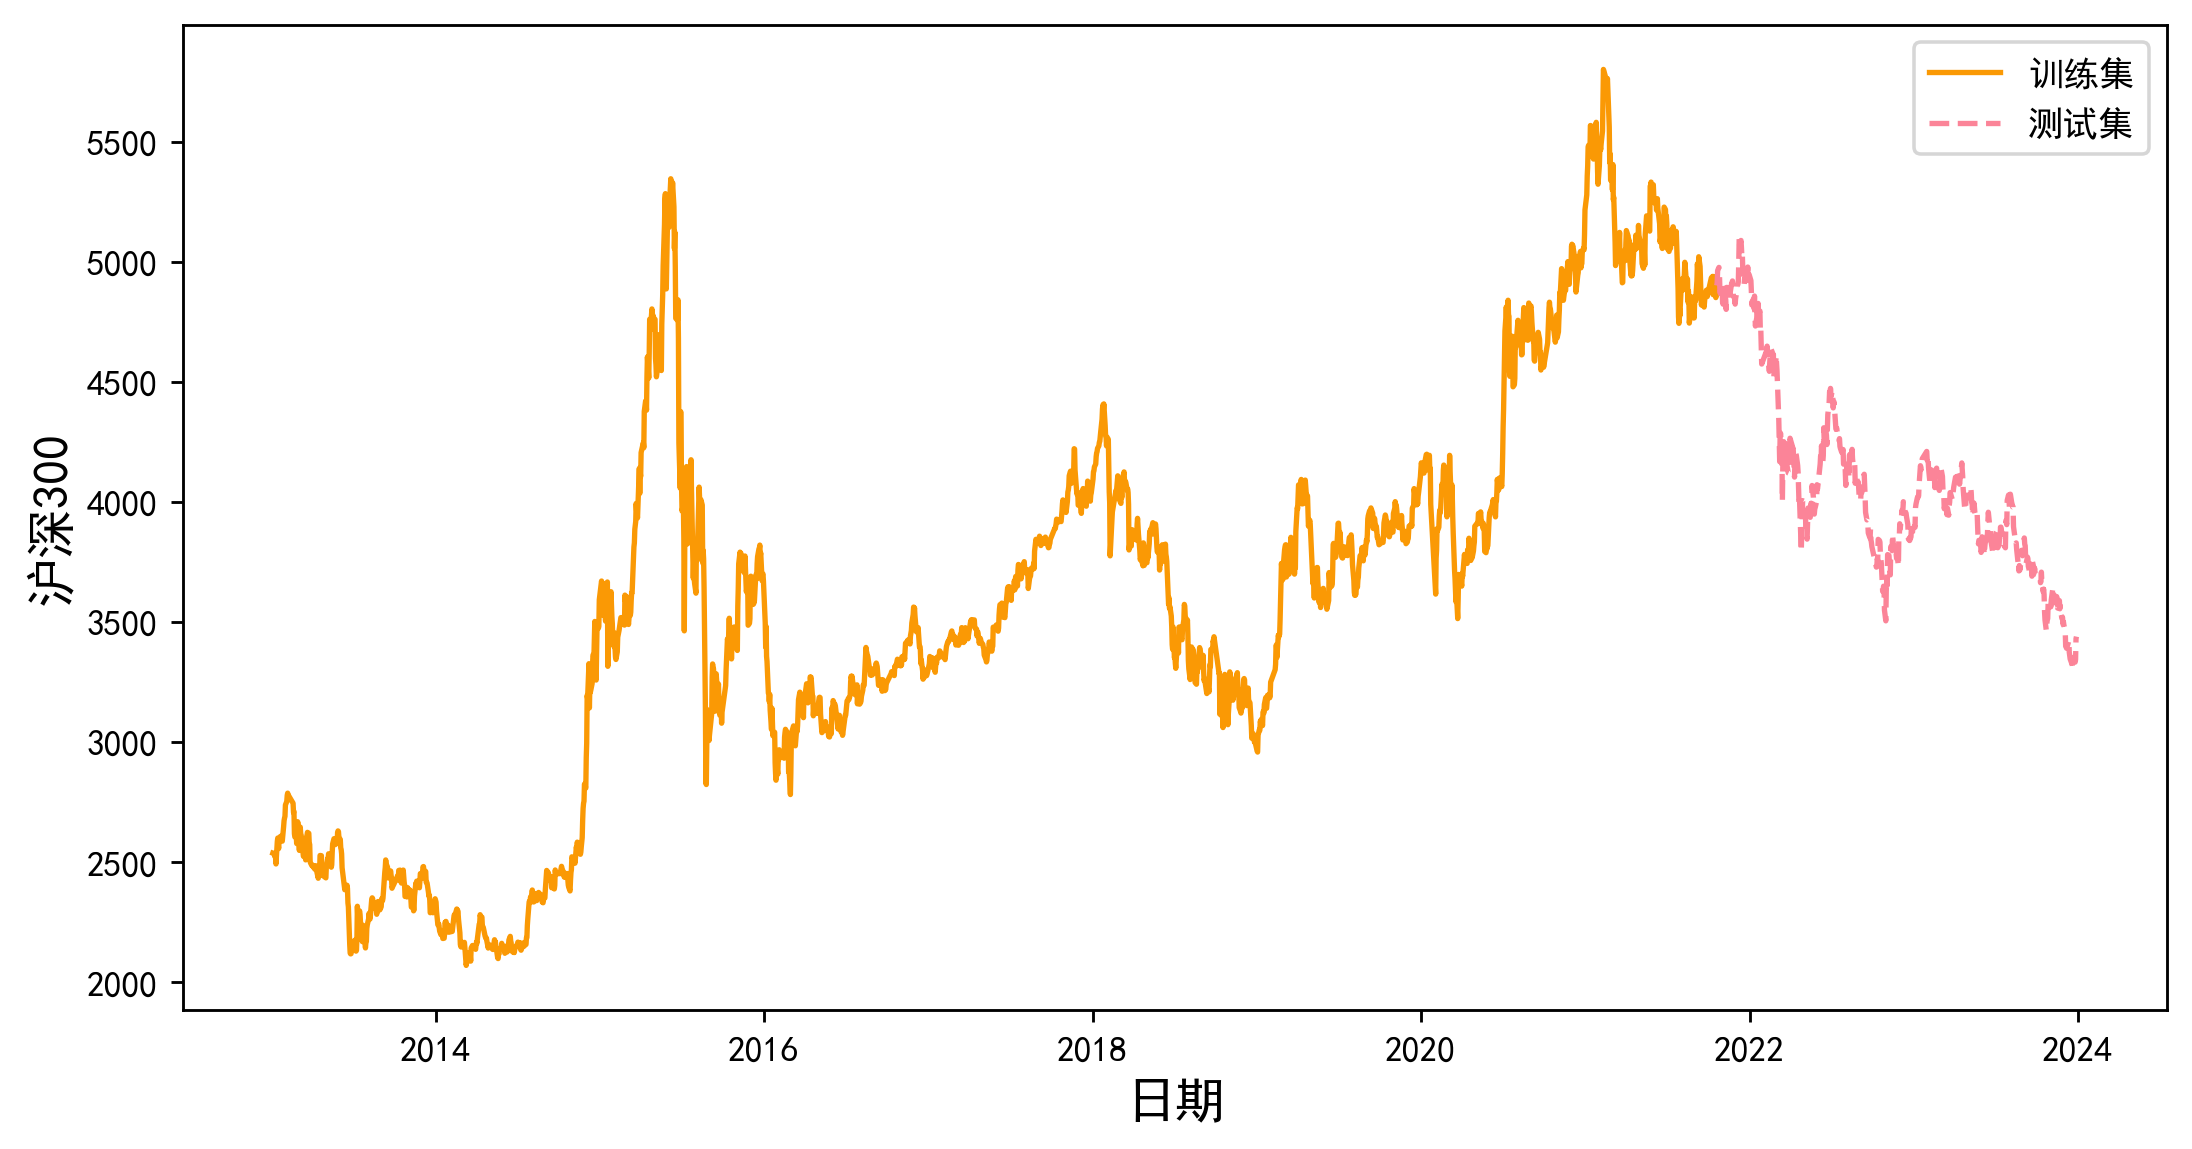

In [6]:
y_test1 = y_scaler.inverse_transform(y_test.reshape(-1,1))
test_size=int(len(data)*(1-train_ratio))
plt.figure(figsize=(10,5),dpi=256)
plt.plot(data0.index[:-test_size],data0.iloc[:,-1].iloc[:-test_size],label='训练集',color='#FA9905')
plt.plot(data0.index[-test_size:],data0.iloc[:,-1].iloc[-(test_size):],label='测试集',color='#FB8498',linestyle='dashed')
plt.legend()
plt.ylabel('沪深300',fontsize=14)
plt.xlabel('日期',fontsize=14)
plt.show()

In [7]:
print(f'训练集开始时间{data0.index[:-test_size][0]},结束时间{data0.index[:-test_size][-1]}')
print(f'测试集开始时间{data0.index[-test_size:][0]},结束时间{data0.index[-test_size:][-1]}')

训练集开始时间2013-01-04 00:00:00,结束时间2021-10-19 00:00:00
测试集开始时间2021-10-20 00:00:00,结束时间2023-12-29 00:00:00


### 定义评价指标

In [8]:
def set_my_seed():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(1)
    rn.seed(12345)
    tf.random.set_seed(123)
    
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    mape=(abs(y_predict -y_test)/ y_test).mean()
    #r_2=r2_score(y_test, y_predict)
    return mse, rmse, mae, mape #r_2

In [9]:
def build_model(X_train,mode='LSTM',hidden_dim=[32,16]):
    set_my_seed()
    model = Sequential()
    if mode=='MLP':
        model.add(Dense(hidden_dim[0],activation='relu',input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(Flatten())
        model.add(Dense(hidden_dim[1],activation='relu'))
    elif mode=='LSTM':
        # LSTM
        model.add(LSTM(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))#
        model.add(Dropout(0.4))
        model.add(LSTM(hidden_dim[1]))
        model.add(Dropout(0.5))
        #model.add(Flatten())
        #model.add(Dense(hidden_dim[1], activation='relu'))
    elif mode=='GRU':
        #GRU
        model.add(GRU(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(GRU(hidden_dim[1]))
    elif mode=='BiLSTM':
        # Bidirectional LSTM
        model.add(Bidirectional(LSTM(hidden_dim[0], return_sequences=True), input_shape=(X_train.shape[-2], X_train.shape[-1])))
        model.add(Dropout(0.4))
        model.add(Bidirectional(LSTM(hidden_dim[1])))
        model.add(Dropout(0.5))

    elif mode=='CNN+LSTM':
        # CNN followed by LSTM
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[-2], X_train.shape[-1])))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(hidden_dim[0]))
        model.add(Dropout(0.4))
        model.add(Dense(hidden_dim[1], activation='relu'))

    elif mode=='CNN+BiLSTM':
        # CNN followed by BiLSTM
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[-2], X_train.shape[-1])))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Bidirectional(LSTM(hidden_dim[0])))
        model.add(Dropout(0.4))
        model.add(Dense(hidden_dim[1], activation='relu'))    
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError(),"mape","mae"])
    return model


In [10]:
def plot_loss(hist,imfname=''):
    plt.subplots(1,4,figsize=(16,4))
    for i,key in enumerate(hist.history.keys()):
        n=int(str('24')+str(i+1))
        plt.subplot(n)
        plt.plot(hist.history[key], 'k', label=f'Training {key}')
        plt.title(f'{imfname} Training {key}')
        plt.xlabel('Epochs')
        plt.ylabel(key)
        plt.legend()
    plt.tight_layout()
    plt.show()
def plot_fit(y_test, y_pred):
    plt.figure(figsize=(4,2))
    plt.plot(y_test, color="red", label="actual")
    plt.plot(y_pred, color="blue", label="predict")
    plt.title(f"拟合值和真实值对比")
    plt.xlabel("Time")
    plt.ylabel('values')
    plt.legend()
    plt.show()

In [11]:
df_eval_all=pd.DataFrame(columns=['MSE','RMSE','MAE','MAPE'])
df_preds_all=pd.DataFrame()
def train_fuc(mode='LSTM',batch_size=4,epochs=30,hidden_dim=[32,16],verbose=0,show_loss=True,show_fit=True):
    #构建模型
    s = time.time()
    set_my_seed()
    model=build_model(X_train=X_train,mode=mode,hidden_dim=hidden_dim)
    earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=5)
    hist=model.fit(X_train, y_train,batch_size=batch_size,epochs=epochs,verbose=verbose,callbacks=[earlystop],validation_data=(X_test, y_test))  #
    print(hist.history.keys())
    if show_loss:
        plot_loss(hist)
            
    #预测
    y_pred = model.predict(X_test)
    y_pred = y_scaler.inverse_transform(y_pred)
    #print(f'真实y的形状：{y_test.shape},预测y的形状：{y_pred.shape}')
    if show_fit:
        plot_fit(y_test1, y_pred)
    e=time.time()
    print(f"运行时间为{round(e-s,3)}")
    df_preds_all[mode]=y_pred.reshape(-1,)
        
    s=list(evaluation(y_test1, y_pred))
    df_eval_all.loc[f'{mode}',:]=s
    s=[round(i,3) for i in s]
    print(f'{mode}的预测效果为：MSE:{s[0]},RMSE:{s[1]},MAE:{s[2]},MAPE:{s[3]}')
    print("=======================================运行结束==========================================")
    return hist

In [42]:
window_size=5
batch_size=128
epochs=10
hidden_dim=[32,16]

verbose=0
show_fit=True
show_loss=True
mode='LSTM'  #MLP,GRU

Epoch 1/10
17/17 [==============================] - 4s 74ms/step - loss: 0.1247 - root_mean_squared_error: 0.3532 - mape: 23090.2910 - mae: 0.2792 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1611 - val_mape: 27.2553 - val_mae: 0.1515
Epoch 2/10
17/17 [==============================] - 0s 19ms/step - loss: 0.0338 - root_mean_squared_error: 0.1840 - mape: 73377.9219 - mae: 0.1444 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364 - val_mape: 4.8276 - val_mae: 0.0274
Epoch 3/10
17/17 [==============================] - 0s 15ms/step - loss: 0.0240 - root_mean_squared_error: 0.1548 - mape: 61072.1953 - mae: 0.1180 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860 - val_mape: 13.5286 - val_mae: 0.0770
Epoch 4/10
17/17 [==============================] - 0s 14ms/step - loss: 0.0200 - root_mean_squared_error: 0.1416 - mape: 59221.1445 - mae: 0.1060 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374 - val_mape: 5.0873 - val_mae: 0.0297
Epoch 5/10
17/17 [================

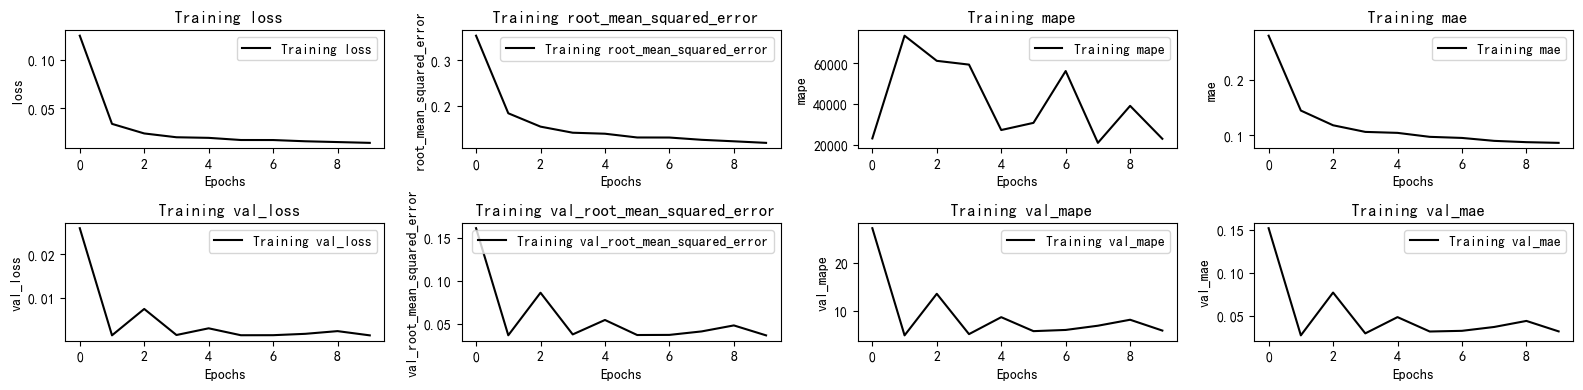

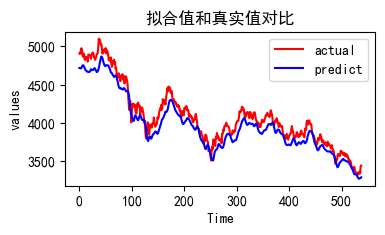

运行时间为8.857
LSTM的预测效果为：MSE:18332.055,RMSE:135.396,MAE:119.414,MAPE:0.029
=======================================运行结束==========================================


In [43]:
hist=train_fuc(mode='LSTM',batch_size=batch_size,epochs=epochs,hidden_dim=hidden_dim,verbose=1)

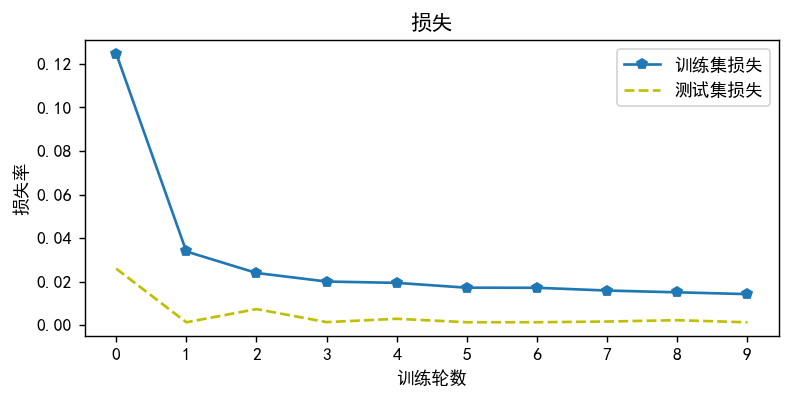

In [44]:
loss=hist.history['loss']
val_loss=hist.history['val_loss']
# 绘制训练和验证的损失值
plt.figure(figsize=(7,3),dpi=128)
plt.plot(range(len(loss)), loss, 'p-', label='训练集损失')
plt.plot(range(len(loss)), val_loss, 'y--', label='测试集损失')
plt.title('损失')
plt.xlabel('训练轮数')
plt.ylabel('损失率')
plt.xticks(range(len(loss)))
plt.legend()
plt.show()

In [45]:
#hist=train_fuc(mode='GRU',batch_size=batch_size,epochs=epochs,hidden_dim=hidden_dim,verbose=0)

dict_keys(['loss', 'root_mean_squared_error', 'mape', 'mae', 'val_loss', 'val_root_mean_squared_error', 'val_mape', 'val_mae'])


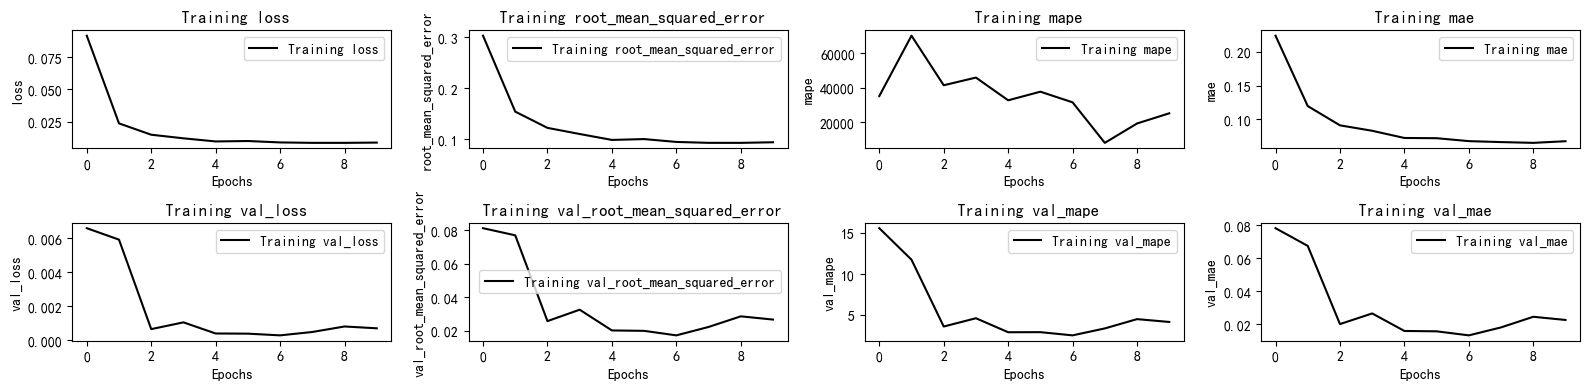

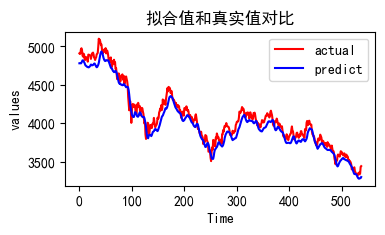

运行时间为13.393
BiLSTM的预测效果为：MSE:9911.279,RMSE:99.555,MAE:84.135,MAPE:0.02
=======================================运行结束==========================================


In [46]:
hist=train_fuc(mode='BiLSTM',batch_size=batch_size,epochs=epochs,hidden_dim=hidden_dim,verbose=0)

dict_keys(['loss', 'root_mean_squared_error', 'mape', 'mae', 'val_loss', 'val_root_mean_squared_error', 'val_mape', 'val_mae'])


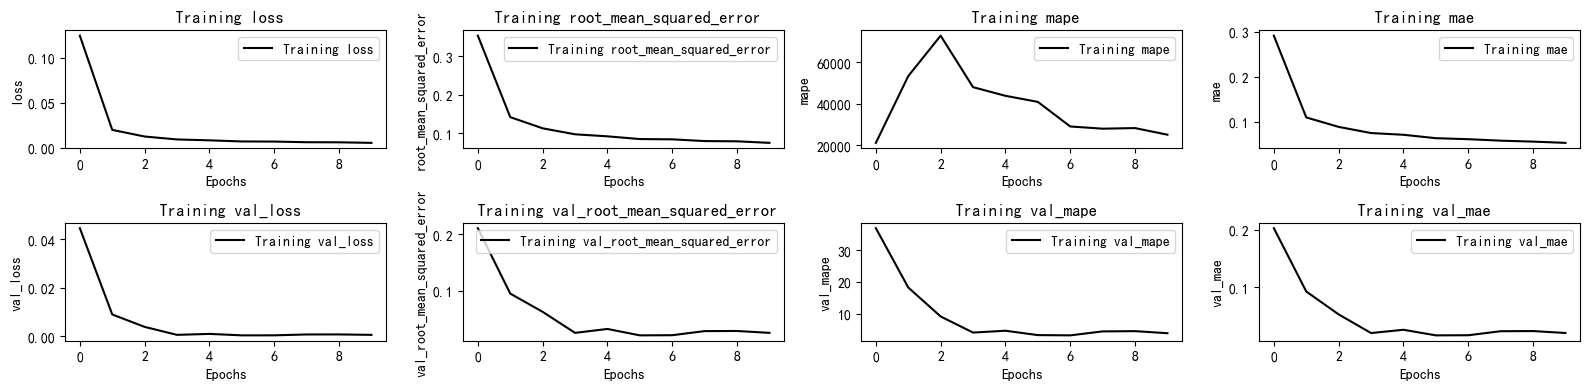

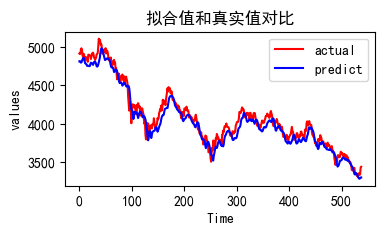

运行时间为5.811
CNN+LSTM的预测效果为：MSE:8945.764,RMSE:94.582,MAE:76.318,MAPE:0.019
=======================================运行结束==========================================


In [47]:
hist=train_fuc(mode='CNN+LSTM',batch_size=batch_size,epochs=epochs,hidden_dim=hidden_dim,verbose=0)

dict_keys(['loss', 'root_mean_squared_error', 'mape', 'mae', 'val_loss', 'val_root_mean_squared_error', 'val_mape', 'val_mae'])


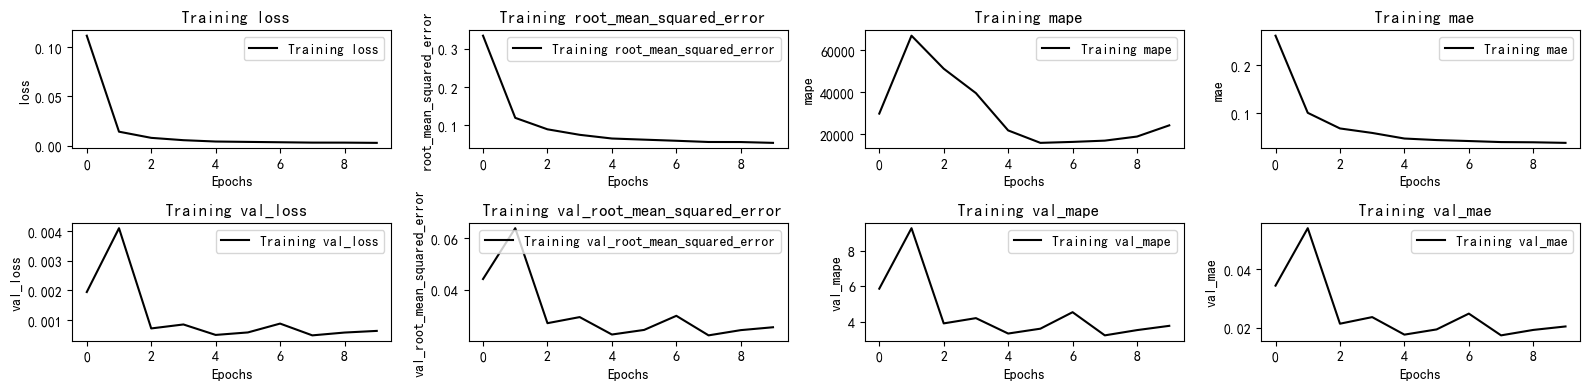

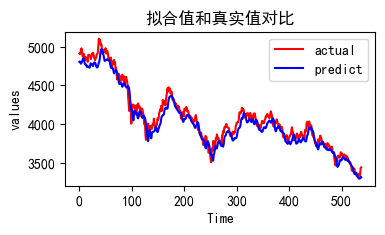

运行时间为7.798
CNN+BiLSTM的预测效果为：MSE:8890.441,RMSE:94.289,MAE:76.166,MAPE:0.018
=======================================运行结束==========================================


In [48]:
hist=train_fuc(mode='CNN+BiLSTM',batch_size=batch_size,epochs=epochs,hidden_dim=hidden_dim,verbose=0)

### 查看评价指标

In [49]:
df_eval_all

,MSE,RMSE,MAE,MAPE
LSTM,18332.055171,135.39592,119.413599,0.028727
BiLSTM,9911.2792,99.555408,84.13501,0.020365
CNN+LSTM,8945.763924,94.582049,76.317549,0.018533
CNN+BiLSTM,8890.441429,94.289137,76.166101,0.018419


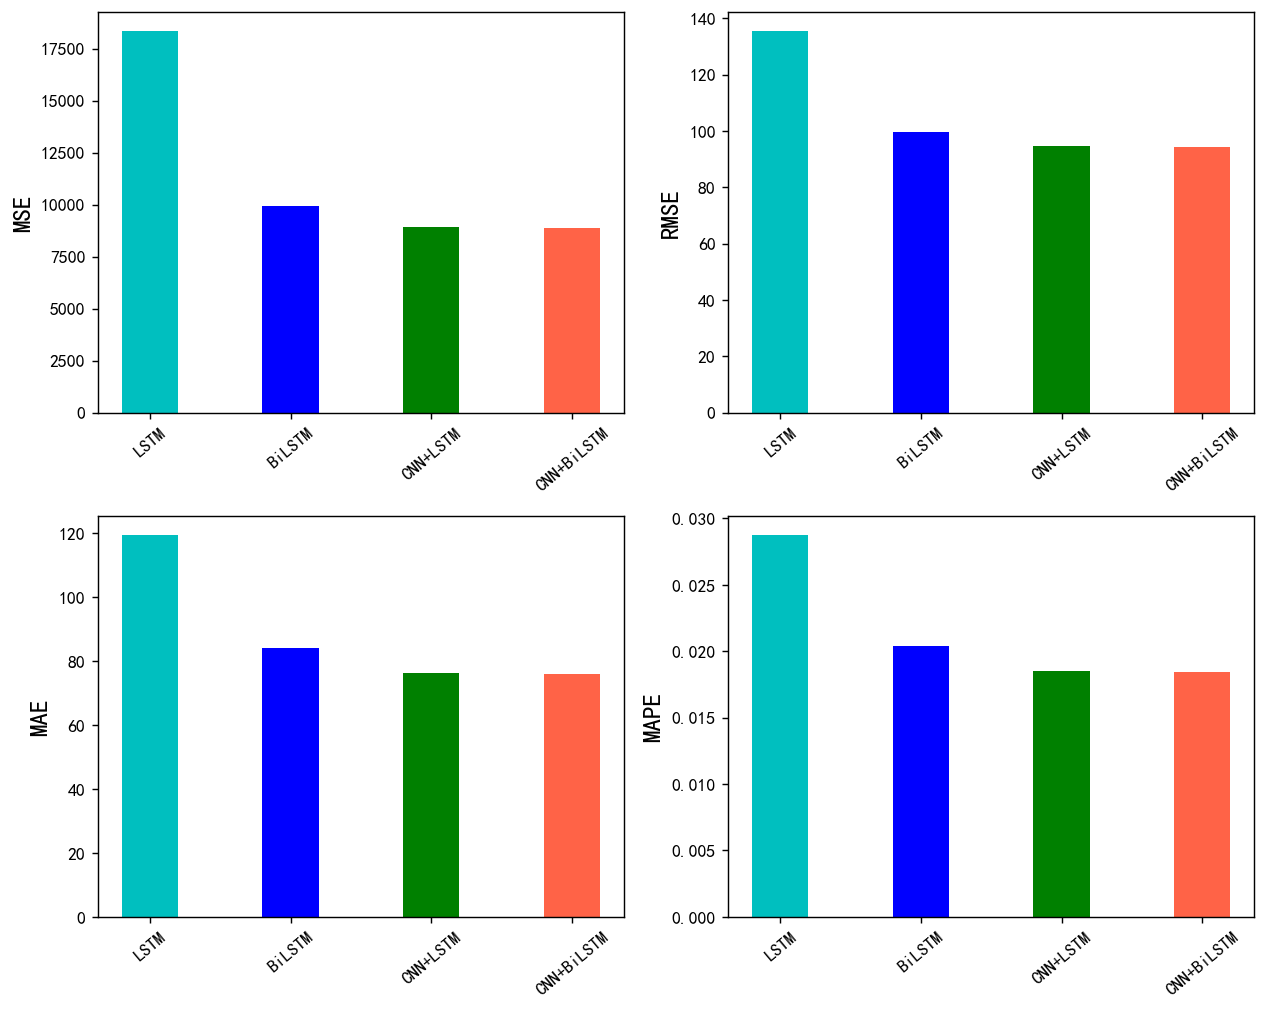

In [50]:
bar_width = 0.4
colors=['c', 'b', 'g', 'tomato', 'm', 'y', 'lime', 'k','orange','pink','grey','tan','gold','r']
fig, ax = plt.subplots(2,2,figsize=(10,8),dpi=128)
for i,col in enumerate(df_eval_all.columns):
    n=int(str('22')+str(i+1))
    plt.subplot(n)
    df_col=df_eval_all[col]
    m =np.arange(len(df_col))
    plt.bar(x=m,height=df_col.to_numpy(),width=bar_width,color=colors)
    
    #plt.xlabel('Methods',fontsize=12)
    names=df_col.index
    plt.xticks(range(len(df_col)),names,fontsize=10)
    plt.xticks(rotation=40)
    plt.ylabel(col,fontsize=14)
    
plt.tight_layout()
#plt.savefig('柱状图.jpg',dpi=512)
plt.show()

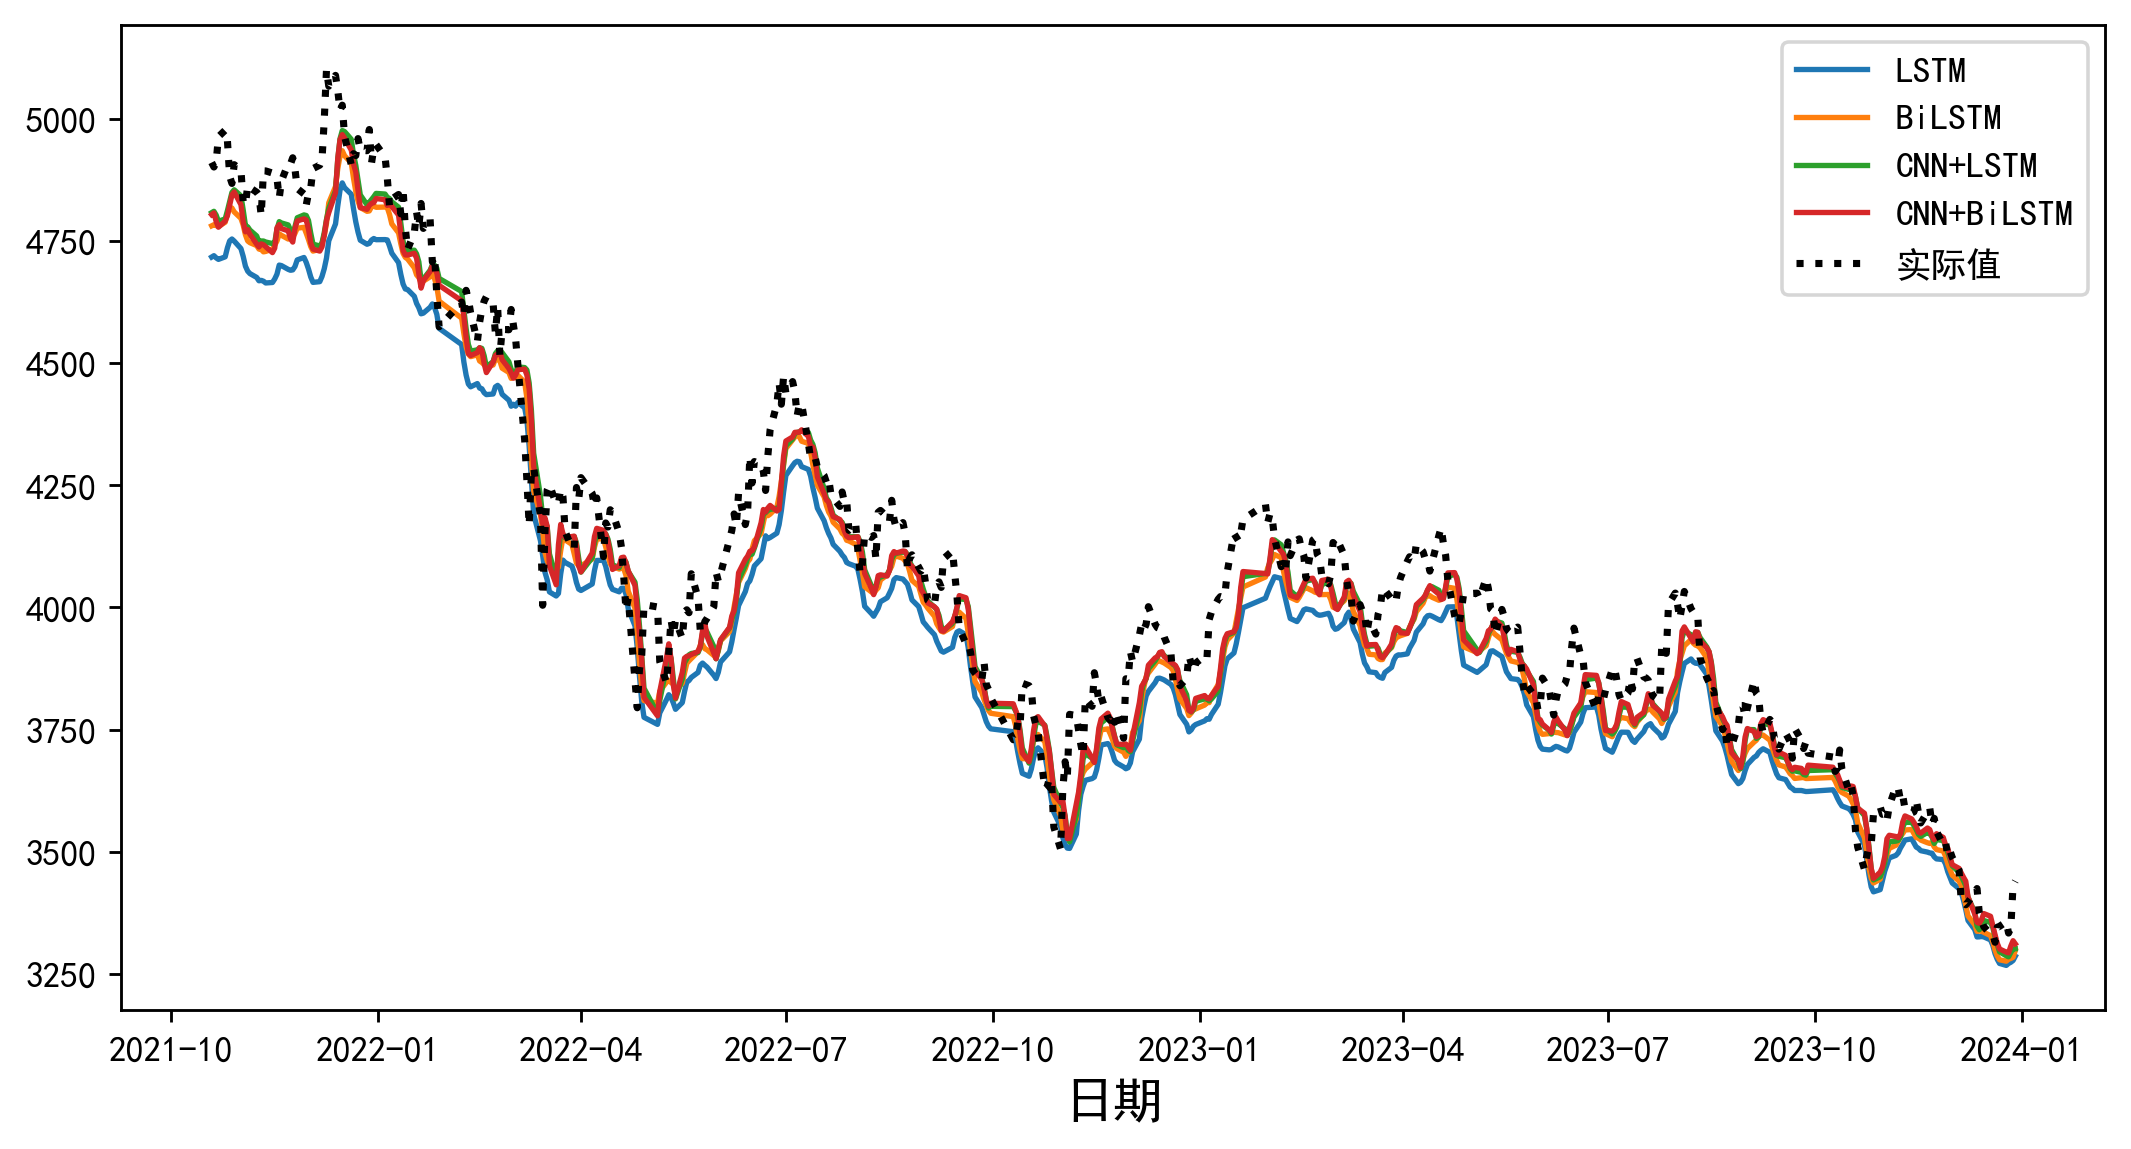

In [51]:
plt.figure(figsize=(10,5),dpi=256)
for i,col in enumerate(df_preds_all.columns):
    plt.plot(data0.index[-test_size-1:],df_preds_all[col],label=col) # ,color=colors[i]

plt.plot(data0.index[-test_size-1:],y_test1.reshape(-1,),label='实际值',color='k',linestyle=':',lw=2)
plt.legend()
plt.ylabel('',fontsize=16)
plt.xlabel('日期',fontsize=14)
#plt.savefig('点估计线对比.jpg',dpi=256)
plt.show()